In [92]:
import copy
from linearmodels.iv import IV2SLS
from statsmodels.stats.outliers_influence import variance_inflation_factor
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
import scipy as sc
import scipy.signal
import scipy.stats
#import sysidentpy as sipy
from scipy.fft import fft, ifft, fftshift
from statsmodels.tsa.stattools import adfuller
import statsmodels.api as sm
from sklearn.metrics import mutual_info_score

from sysidentpy.metrics import mean_squared_error
from sysidentpy.model_structure_selection import FROLS
from sysidentpy.basis_function._basis_function import Polynomial
from sysidentpy.utils.display_results import results
from sysidentpy.utils.plotting import plot_residues_correlation, plot_results
from sysidentpy.residues.residues_correlation import compute_residues_autocorrelation, compute_cross_correlation
from IPython.display import display, HTML
from pmdarima import auto_arima
from sklearn.metrics import mean_squared_error

plt.rc('font', size=30)          # controls default text sizes
plt.rc('axes', titlesize=25)     # fontsize of the axes title
plt.rc('axes', labelsize=25)     # fontsize of the x and y labels
plt.rc('xtick', labelsize=25)    # fontsize of the tick labels
plt.rc('ytick', labelsize=25)    # fontsize of the tick labels
plt.rc('legend', fontsize=25)    # legend fontsize
plt.rc('lines', linewidth=3)     # linewidth

df1 = pd.read_csv('data/U3.ASC', sep="\s+", names=['time', 'y', 'u'])
df2 = pd.read_csv('data/U1.ASC', sep="\s+", names=['time', 'y', 'u'])

# cut
df1 = df1.iloc[301:1500]
df2 = df2.iloc[301:930]

# z-normalise
joint_avg_u = np.average(df1['u'].append(df2['u']))
joint_avg_y = np.average(df1['y'].append(df2['y']))
joint_std_u = np.std(df1['u'].append(df2['u']))
joint_std_y = np.std(df1['y'].append(df2['y']))
df1['u'] = (df1['u']-joint_avg_u)/joint_std_u
df1['y'] = (df1['y']-joint_avg_y)/joint_std_y
df2['u'] = (df2['u']-joint_avg_u)/joint_std_u
df2['y'] = (df2['y']-joint_avg_y)/joint_std_y

# u_train = np.asarray(df2['u']).reshape(-1, 1)
# u_valid = np.asarray(df1['u']).reshape(-1, 1)
# y_train = np.asarray(df2['y']).reshape(-1,1)
# y_valid = np.asarray(df1['y']).reshape(-1,1)

/tmp/ipykernel_418253/4270553456.py:42: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  joint_avg_u = np.average(df1['u'].append(df2['u']))
/tmp/ipykernel_418253/4270553456.py:43: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  joint_avg_y = np.average(df1['y'].append(df2['y']))
/tmp/ipykernel_418253/4270553456.py:44: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  joint_std_u = np.std(df1['u'].append(df2['u']))
/tmp/ipykernel_418253/4270553456.py:45: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  joint_std_y = np.std(df1['y'].append(df2['y']))


## Prepare data
### (Comment: when creating the lagged data we drop some values in $y$ and $u$ and thus loose the characteristic spectrum of PRBS. If instead of cutting the table short, we loop it (so that the we retain the full PRSB signal, we get a very similar performance).

In [93]:
# make a copy of the training and test data
df_2 = copy.deepcopy(df2)
df_1 = copy.deepcopy(df1)

# define lags
lag = 3

# create a list of labels
lagged_u = ['u_lag'+str(i) for i in range(1, lag+1)]

# adding lags to the dataset
for i in range(1, lag+1):
    df_2['u_lag' + str(i)] = df_2['u'].shift(i)
for i in range(1, lag+1):
    df_1['u_lag' + str(i)] = df_1['u'].shift(i)

# dropping NA values (created due to shifting)
df_2 = df_2.dropna()
df_1 = df_1.dropna()

In [94]:
X = df_2[lagged_u]
y = df_2['y']

model = auto_arima(y=y, X=X, d=0, seasonal=False,
                   error_action='ignore', suppress_warnings=True,
                   max_p=lag, max_q=lag, trace=True)
#model.fit(y,exog)

print(model.arparams)
print(model.maparams)
#print(model.exparams)
#print(model.sigma2)

# Create predictions for the future, evaluate on test
#preds, conf_int = model.predict(n_periods=len(exog), return_conf_int=True)

#plt.plot(preds)

Performing stepwise search to minimize aic
 ARIMA(2,0,2)(0,0,0)[0]             : AIC=-2297.572, Time=0.47 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=1308.174, Time=0.05 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=-805.474, Time=0.12 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=516.485, Time=0.12 sec
 ARIMA(1,0,2)(0,0,0)[0]             : AIC=-1721.686, Time=0.39 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=-2159.233, Time=0.41 sec
 ARIMA(3,0,2)(0,0,0)[0]             : AIC=-2446.747, Time=0.50 sec
 ARIMA(3,0,1)(0,0,0)[0]             : AIC=-2140.359, Time=0.48 sec
 ARIMA(3,0,3)(0,0,0)[0]             : AIC=-2214.264, Time=0.59 sec
 ARIMA(2,0,3)(0,0,0)[0]             : AIC=-2353.291, Time=0.64 sec
 ARIMA(3,0,2)(0,0,0)[0] intercept   : AIC=-2441.669, Time=0.51 sec

Best model:  ARIMA(3,0,2)(0,0,0)[0]          
Total fit time: 4.259 seconds
<function ARIMA.arparams at 0x7f0bec8a0700>
<function ARIMA.maparams at 0x7f0bec8a0700>


Train RMSE: 0.033696366170286055


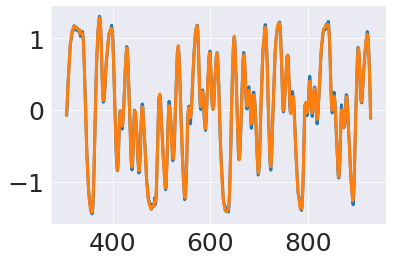

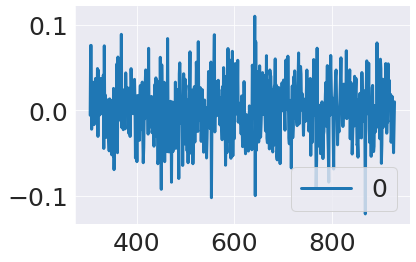

In [95]:
# Generate predictions
train_preds = model.predict_in_sample(X=X)

# Calculate metrics
train_rmse = np.sqrt(mean_squared_error(df_2['y'], train_preds))

print(f'Train RMSE: {train_rmse}')

# Plot train predictions
plt.plot(train_preds)
plt.plot(df_2['y'])
plt.show()

# Plot residuals
residuals = pd.DataFrame(model.resid())
residuals.plot()
plt.show()

In [96]:
def simulate_arima(model, y_init, exog, steps):
    """
    Simulates an ARIMA model.

    Parameters:
    model: The fitted ARIMA model.
    y_init: The initial conditions for the endogenous variable.
    exog: The exogenous variables for the simulation.
    steps: The number of steps to simulate.

    Returns:
    A list with the simulated values.
    """

    # Initialize the simulated values with the initial conditions
    y_sim = list(y_init)

    # For each step in the simulation
    for t in range(steps):

        # Make a one-step ahead forecast
        y_pred = model.predict(n_periods=1, exogenous=exog.iloc[t])

        # Append the forecast to the simulated values
        y_sim.append(y_pred[0])

        # Update the initial conditions with the forecast
        y_init = np.roll(y_init, -1)
        y_init[-1] = y_pred[0]

    # Return the simulated values
    return y_sim


train_preds = simulate_arima(model=model,
                             y_init=df2['y'][lag:],
                             exog=X,
                             steps=200)

plt.plot(train_preds)

ValueError: When an ARIMA is fit with an X array, it must also be provided one for predicting or updating observations.